<div class="clearfix" style="padding: 10px; padding-left: 0px">
<img src="unilogoblack.jpeg" width="250px" style="display: inline-block; margin-top: 5px;">
<a href="http://www.python.org"><img src="Python-logo-notext.svg" width="70px" class="pull-right" style="display: inline-block; margin: 0px;"></a>
</div>


# Basic Scientific Python

J. D. Nichols 2015




## Section 10: Solving differential equations

### ODEs

The acronym ODE stands for "ordinary differential equation", the "ordinary" implying the use of full, as opposed to partial, derivatives. Differential equations describe how parameters vary in relation to other parameters, and are the fundamental basis of physics - the universe would be pretty boring if nothing ever varied with respect to anything else.  So, to study the universe, we need to solve differential equations, and you will have met a number of these already in your physics and maths modules. Only the simplest differential equations have analytically tractable solutions (many books have been written about these), and for the rest we must use some numerical method that approximates the 'true' solution (many more books have been written about these).  As you might expect, Scipy contains routines for numerically solving differential equations.  These are relatively easy to use, and we will use them soon, but there is a danger that if we dive right in we will not gain an understanding of how numerical solvers work in general.  So first, we'll take a quick look at a basic process called the *Runge-Kutta method* (after the German mathematicians Carl Runge and Martin Kutta), and then we'll go on to use the Scipy function `odeint`, which contains many bells and whistles, including automatically selecting which scheme to use based on the problem in hand.

The differential equations to be solved describe the physical system being modelled, although the equations are not the whole story; much of the interesting physics derives from the boundary conditions required to solve the equations.  We will concentrate here on "initial value problems", i.e. problems in which the boundary conditions are all specified at one point, at the outset of computation; there are other problems for which this is not the case, but these are outside the scope of the present course.  

We begin by formulating the problem in terms of first-order differential equations.  All differential equations can be arranged as a set of first-order equations: second-order equations can be re-arranged to two first-order equations, third-order equations become three first-order equations, etc.  Hence, e.g. the second-order equation

$$\frac{d^2y}{dx^2}+f(x)\frac{dy}{dx}-g(x)=0$$

can be re-arranged as two first-order equations as follows:

$$\frac{dy}{dx}=z(x)\;\;,$$
$$\frac{dz}{dx}=g(x)-f(x)z(x)\;\;.$$

The basic principle behind all numerical initial value problem solvers is then to rewrite the continuous rates of change, e.g. $dy$, $dz$ and $dx$ for our example, in terms of finite but small differences, i.e. $\Delta y$, $\Delta z$ and $\Delta x$ here, and multiply the equations by $\Delta x$ to obtain an expression for, in our case, $\Delta y$ and $\Delta z$ for each step change $\Delta x$.  Given some initial values $y_0$ and $z_0$ at $x_0$, we can then compute the the next value of $y$ and $z$, and then the next, etc. until we have reached the edge of our *solution domain*, i.e. the region of $x$ over which we wish to calculate the solution.  For our example, therefore, we would have:

$$y_{n+1} = y_n + z_n\Delta x\;\;,$$
$$z_{n+1} = z_n + g(x)\Delta x - f(x)z_n\Delta x\;\;.$$

You have already solved one initial value problem using this method in Section 8!  This scheme is called the *Euler method*, and is the simplest numerical procedure for solving differential equations.  However, it turns out that this method can produce quite unstable results and does not approximate the 'true' solution as well as some more complex schemes, so is actually rarely used.  The problem is illustrated by the following Figure: 

<img src="rkeuler.png" width="70%" style="display: inline-block; margin-top: 5px;">

The value of the derivative is calculated at the start of each interval in $\Delta x$ as shown by the blue arrows, e.g. starting at $x_1$ in the above Figure.  By the end of each interval, e.g. at $x_2$, the gradient will probably have changed, but this is not taken into account in the result, and the value of $y$ extrapolated using a straight line from $x_1$ (the blue x) will therefore be slightly different to the 'real' value at $x_2$.  The effect is exaggerated in the Figure, but these differences add up over the course of the integration, and can lead to significant errors in regions where the gradient changes sharply. The Runge-Kutta method attempts to alleviate this by using the derivative at the start of the interval to find the value at the midpoint, shown by the blue circle, then using instead the derivative at this midpoint (shown by the red arrow) for the whole interval, as shown by the red line, rather than the derivative calculated at the start. The calculated value of $y$ at $x_2$, shown by the red x is then typically closer to the true value than that determined by the Euler method in blue. This scheme is specifically known as the *second order Runge-Kutta* or *midpoint method*, and there are higher orders that exist.  The most commonly used is the *fourth-order Runge-Kutta method*, or *RK4* for short, and this calculates the derivative at 4 places for each interval.  

More generenally, the value of the solution at the $n+1^{th}$ point $y_{n+1}$ as calculated from the $n^{th}$ point $y_n$ using the Euler method is

$$y_{n+1}=y_n+hf(x_n,y_n)+O(h^2)\;\;,$$

where $h$ is the step interval between $x_n$ and $x_{n+1}$ (sometimes called the *timestep* interval, particularly if the abscissa is time) and $O(h^2)$ is the estimated error between the computed and true solutions, here of order $h^2$. Using the second order Runge-Kutta method, the solution is given instead by

$$k_1=hf(x_n,y_n)\;\;,$$
$$k_2=hf(x_n+\frac{1}{2}h,y_n+\frac{1}{2}k_1)$$
$$y_{n+1}=y_n+k_2+O(h^3)\;\;,$$

where here the error is of order $h^3$ (i.e. smaller, for small values of $h$).  

With this introduction, let's revive the orbit simulation code from Section 9, in order to examine the Euler and midpoint methods in action.  Run the following code, and **take a look through it to make sure you understand what is happening**.

/cm/shared/apps/python/2.7.12/lib/python2.7/site-packages/ipykernel/__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


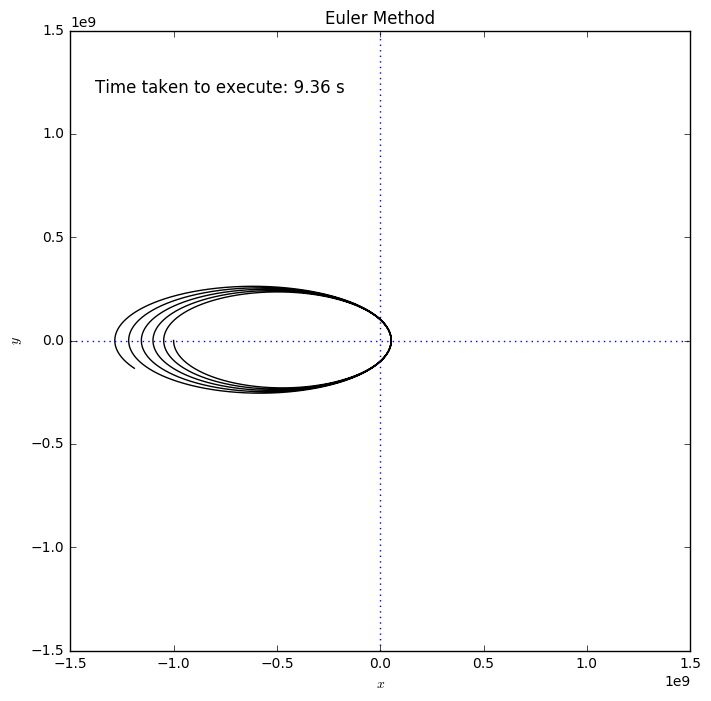

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline


# This function advances the solution by one timestep using the Euler method:
# u is the system state (variables giving position, speed etc.)
# h is the timestep
# p gives system parameters
def euler(u, h, p):
    """Iterates the state of motion by timestep
        using the Euler Method"""

# Unpack the state of motion and the system parameters
    x, vx, y, vy = u
    G, m = p

# Compute the acceleration due to a point-like body's gravity on a test particle    
    r = np.array([x, y])
    d = np.sqrt(np.sum(r**2))
    ag = -G*m*r/d**3     

# Compute the velocity and position components using the Euler method
    x1 = x + vx*h
    y1 = y + vy*h
    vx1 = vx + ag[0]*h
    vy1 = vy + ag[1]*h
    
# Pack the result in a tuple and return    
    res = (x1, vx1, y1, vy1)
    return res


# This function calculates the solution over the whole domain between t0 and t1 with a 
# given timestep h

def numsol(u, t0, t1, h, p):
    """Repeatedly calls the numerical solver to cover the 
       entire solution domain, and returns the state of motion
       as a Numpy RecArray"""
    
# Create abscissa array
    nt = (t1 - t0)/ h
    tarr = np.linspace(t0,t1,nt)
    
# Create an empty (zeroed) Recarray of length nt to store the four variables of motion   
    dm = np.zeros(nt)
    soln = np.rec.fromarrays((dm, dm, dm, dm),
            dtype=[('x', 'f8'), ('vx', 'f8'),('y', 'f8'), ('vy', 'f8')])

# Repeatedly call the numerical solver at each timestep and store the result in soln
    for i, t in enumerate(tarr):
        u = euler(u, h, p)
        soln[i] = u      
    return soln

# Execution starts here! Get the system clock time at the start of execution.
start = time.time()

# Define some constants that comprise the system parameters
G = 6.67384E-11 #Newton's constant of Universal Gravitation
m = 6E24        #Mass of the Earth in kg

# Define the initial conditions in m and ms^-1
x0 = -1E9
y0 = 0.
vx0 = 0.
vy0 = -2.E2

params = [G, m]
init = [x0, vx0, y0, vy0]

# Define solution domain and timestep
n = 10*1E5 #Number of points
t0 = 0.
tend = 10*2.358E6 # Lunar orbital period
h = (tend - t0)/n

# Compute the solution
u = numsol(init, t0, tend, h, params)

# Get the system clock time at the end of execution of solver.
end = time.time()

# Plot
f = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.plot(u.x, u.y, 'k')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title('Euler Method')
ax.set_ylim([-1.5E9,1.5E9])
ax.set_xlim([-1.5E9,1.5E9])
ax.axvline(0,ls=':')
ax.axhline(0,ls=':')
ax.set_aspect('equal')
ax.text(0.04,0.9,'Time taken to execute: {:.2f} s'.format(end - start),transform=ax.transAxes, size='large')
plt.draw()
plt.show()





OK, so we've plotted the orbit of the asteroid, but something is apparently going wrong - the apoapsis of the orbit is increasing with each orbit.  This is telling us that at the periapsis, the velocity is increased over that expected (this is actually how spacecrafts change their orbits - with delta-Vs at periapsis or apoapsis). This is happening because at periapsis, the acceleration changes very quickly with distance and the Euler method is overestimating the velocity at each timestep.  From our discussion above, we know that the Runge-Kutta method produces more accurate results.  Run the following version that uses the midpoint method:

/cm/shared/apps/python/2.7.12/lib/python2.7/site-packages/ipykernel/__main__.py:67: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


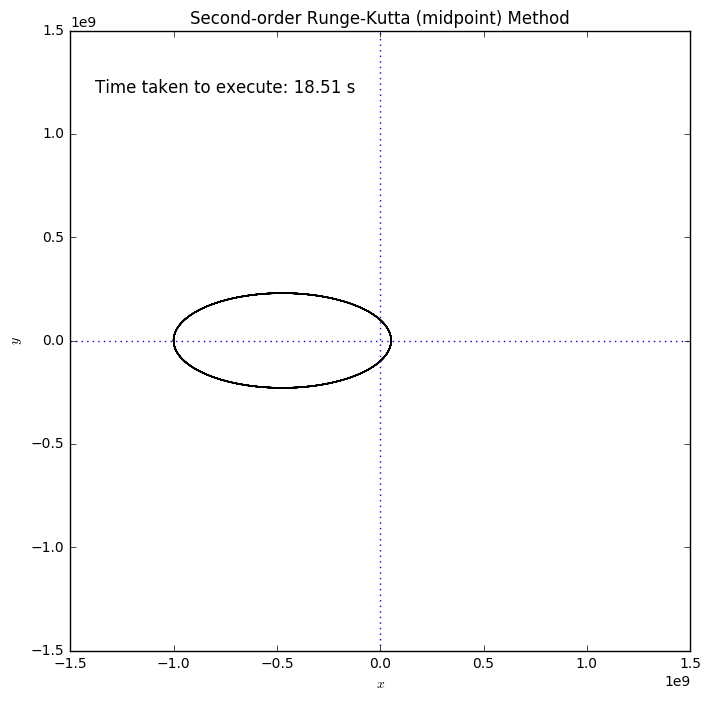

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline
    
# This function advances the solution by one timestep using the 
# second-order Runge-Kutta Method:
# u is the system state (variables giving position, speed etc.)
# h is the timestep
# p gives system parameters   
def runkut2(u, h, p):
    """Iterates the state of motion by timestep
        using the second-order Runge-Kutta Method"""

# Unpack the state of motion and the system parameters
    x, vx, y, vy = u
    G, m = p

# Compute the acceleration due to a point-like body's gravity on a test particle    
    r = np.array([x, y])
    d = np.sqrt(np.sum(r**2))
    ag = -G*m*r/d**3       
    
# Compute the rates of change of the velocity and position 
# components from the values at the start of the interval
    k1x = vx*h
    k1y = vy*h
    k1vx = ag[0]*h  
    k1vy = ag[1]*h
    
# Use these to compute the position at the mid-point of the interval and
# compute the acceleration due to a point-like body's gravity on a test particle    
    rmid = np.array([x + 0.5*k1x, y + 0.5*k1y])
    dmid = np.sqrt(np.sum(rmid**2))
    ag = -G*m*rmid/dmid**3
    
# Compute the rates of change of the velocity and position 
# components from the values at the mid-point of the interval
    k2x = (vx + 0.5*k1vx)*h
    k2y = (vy + 0.5*k1vy)*h
    k2vx = ag[0]*h  
    k2vy = ag[1]*h

# Calculate the final position and velocity values     
    x1 = x + k2x
    y1 = y + k2y
    vx1 = vx + k2vx
    vy1 = vy + k2vy
    
# Pack the result in a tuple and return    
    res = (x1, vx1, y1, vy1)
    return res
    
# This function calculates the solution over the whole domain between t0 and t1 with a 
# given timestep h

def numsol(u, t0, t1, h, p):
    """Repeatedly calls the numerical solver to cover the 
       entire solution domain, and returns the state of motion
       as a Numpy RecArray"""
    
# Create abscissa array
    nt = (t1 - t0)/ h
    tarr = np.linspace(t0,t1,nt)
    
# Create an empty (zeroed) Recarray of length nt to store the four variables of motion   
    dm = np.zeros(nt)
    soln = np.rec.fromarrays((dm, dm, dm, dm),
            dtype=[('x', 'f8'), ('vx', 'f8'),('y', 'f8'), ('vy', 'f8')])

# Repeatedly call the numerical solver at each timestep and store the result in soln
    for i, t in enumerate(tarr):
        u = runkut2(u, h, p)
        soln[i] = u       
    return soln

# Execution starts here!  Get the system clock time at the start of execution.
start = time.time()

# Define some constants that comprise the system parameters
G = 6.67384E-11 #Newton's constant of Universal Gravitation
m = 6E24        #Mass of the Earth in kg

# Define the initial conditions in m and ms^-1
x0 = -1E9
y0 = 0.
vx0 = 0.
vy0 = -2.E2

params = [G, m]
init = [x0, vx0, y0, vy0]

# Define solution domain and timestep
n = 10.*1E5
t0 = 0.
tend = 10*2.358E6 # Lunar orbital period
h = (tend - t0)/n

# Compute the solution
u = numsol(init, t0, tend, h, params)

# Get the system clock time at the end of execution of solver.
end = time.time()


# Plot
f = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.plot(u.x, u.y, 'k')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title('Second-order Runge-Kutta (midpoint) Method')
ax.set_ylim([-1.5E9,1.5E9])
ax.set_xlim([-1.5E9,1.5E9])
ax.axvline(0,ls=':')
ax.axhline(0,ls=':')
ax.set_aspect('equal')
ax.text(0.04,0.9,'Time taken to execute: {:.2f} s'.format(end - start),transform=ax.transAxes, size='large')
plt.draw()
plt.show()



OK, now we have an orbit that looks more sensible - the ellipse that is expected on the basis of Newtonian mechanics in this case - at the cost of increased runtime, which isn't great.  However, now we've got some idea of how numerical solvers work, we can take a look at using the Scipy function `odeint`, which calls a FORTRAN routine called LSODA that resides in a library of numerical equation solvers called ODEPACK (see the [ODEPACK website](https://computation.llnl.gov/casc/odepack/) for more information).  This function makes use of quite advanced, well optimised methods, and can do fancy things like change the timestep size automatically if the solution variables start changing rapidly (referred to as a 'stiff' system).  The details are beyond the scope of this course but if you find yourself using numerical equation solvers elsewhere in your studies, it's worth spending some time reading about how these schemes work.  The book Numerical Recipes by Press et al. is a useful starting point.

<div class="alert alert-info" style="width: 60%; margin-left: 20%; margin-top:20px">
<p>**HINT**</p>
<p> In general, one should always try and avoid using 'black boxes' if at all possible; if someone were to query exactly how you calculated your numbers it's nice to be able to tell them! Having said that, there is not much point in re-inventing the wheel.  So, good rules of thumb are: if you do use pre-written code, make sure you try and understand what it's doing, and only use code that has been well-tested and validated.
</p>
</div>

Anyway, here's how to use `odeint` for our example:

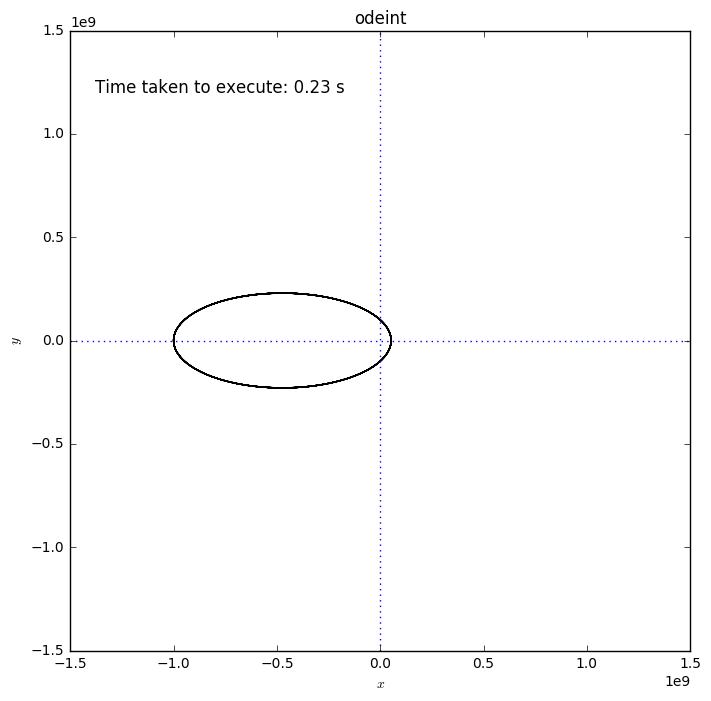

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import time
%matplotlib inline


# This function returns the derivatives of the dependent variables 
# u is the system state (variables giving position, speed etc.)
# t is the time abscissa 
# p gives system parameters
def derivs(u, t, p):
    """docstring for rhs"""
    
# Unpack the state of motion and the system parameters
    x, vx, y, vy = u
    G, m = p
    
# Compute the derivatives of the position and velocity; 
# these are the velocity and acceleration (obviously!).
# Compute the acceleration due to a point-like body's gravity 
# on a test particle. Its velocity is already known from the input. 
    r = np.array([x, y])
    d = np.sqrt(np.sum(r**2))
    ag = -G*m*r/d**3       
    res = (vx, ag[0],vy, ag[1])
    return res

# Execution starts here! Get the system clock time at the start of execution.
start = time.time()

# Define some constants that comprise the system parameters
G = 6.67384E-11 #Newton's constant of Universal Gravitation
m = 6E24        #Mass of the Earth in kg

# Define the initial conditions in m and ms^-1
x0 = -1E9
y0 = 0.
vx0 = 0.
vy0 = -2.E2

params = [G, m]
init = [x0, vx0, y0, vy0]

# Define solution domain and timestep
n = 10*1E5
t0 = 0.
tend = 10*2.358E6 # Lunar orbital period
t = np.linspace(t0,tend,n)

# Compute the solution
u = odeint(derivs, init, t, args=(params,))
x, vx, y, vy = u[:, 0], u[:, 1], u[:, 2], u[:, 3]

# Get the system clock time at the end of execution of solver.
end = time.time()

f = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.plot(x, y, 'k')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title('odeint')
ax.set_ylim([-1.5E9,1.5E9])
ax.set_xlim([-1.5E9,1.5E9])
ax.axvline(0,ls=':')
ax.axhline(0,ls=':')
ax.set_aspect('equal')
ax.text(0.04,0.9,'Time taken to execute: {:.2f} s'.format(end - start),transform=ax.transAxes, size='large')
plt.draw()
plt.show()

Not only is this much simpler - we merely have to specify the derivatives - but `odeint` is more accurate and over a hundred times faster than our Python loop!  This difference between ~0.1 s and ~10 s might not seem much when running this once, but imagine if you had to run it a hundred thousand times... `odeint` would finish in ~3 h whereas our code would take ~11 days!



#### Task 10.1
Recall our system from Section 6, in which two identical bodies of mass $m$ sit on a frictionless surface and are coupled by springs with spring constants $k_1$, $k_2$, and $k_3$, to each other and two immovable walls as in the following figure:

<img src="coupled.png" width="70%" style="display: inline-block; margin-top: 5px;">

If the displacement of the masses from the unstretched, equilibrium positions are $x_1$ and $x_2$, we had the following equations of motion for the two springs:

$$m\ddot{x}_1 = -k_1x_1 + k_2(x_2-x_1)\;\;,$$
$$m\ddot{x}_2 = -k_2(x_2-x_1) + k_3(-x_2)\;\;.$$

Use `odeint` to solve these equations over a solution domain with 10,000 points between $0\le t\le500$, and then plot the displacement of the two masses versus time.  Assume initially that $k_1=k_2=k_3=1$, $m=1$, $x_{10}=0.5$ and $x_{20}=0$. Investigate what effect changing the various parameters has on the system.  For example, consider the relative strengths of the spring, the weights of the masses and the relative initial displacement.  Write down your findings in the cell below.

<type 'numpy.ndarray'>


Double-click to edit me.

#### Task 10.2
The *Lorenz equations* were initially derived to model atmospheric dynamics, and comprise the following three coupled ODEs:

$$\dot{x}=\sigma(y-x)\;\;,$$
$$\dot{y}=\rho x-y-xz\;\;,$$
$$\dot{z}=xy-\beta z\;\;,$$

where $\sigma=10$, $\beta=8/3$, and $\rho$ is a free parameter.  Use `odeint` to solve these equations over a solution domain with 20,000 points between $0\le t\le50$, and then plot $x$, $y$, and $z$ on a 3D plot using `Axes3D`.  Examine the behaviour of the system for various different values of $0<\rho<30$.  Write down your findings in the cell below.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import time
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def derivs(u, t, p):

# Unpack the state of motion and the system parameters
    x,  y,  z = u
    sigma, rho, beta = p
    
    vx = sigma*(y - x)
    vy = rho*x - y - x*z
    vz = x*y - beta*z
    res = (vx, vy, vz)
    return res

# Sart timer
start = time.time()

# Set constants, and starting position
sigma = 10
beta = 8./3
rho = 28

#x0 = 200.
#y0 = 200.
#z0 = 200.

#n = 20000
#x0 = 0.
#xend = 50.
x = np.linspace(0., 50., 20000)
y, z = 2*x, 4*x
params = [sigma, beta, rho]
init = [x, y, z]

# Set values to be calculated over
#n = 2e5
#x0 = 0.
#xend = 50.
#x = np.linspace(t0, tend, n)

# compute solutions
u = odeint(derivs, init, t, args=(params, ))
x, y, z = u[:, 0], u[:, 1], u[:, 2]

end = time.time()

f = plt.figure(1, figsize=(13,10))
ax = f.add_subplot(111, projection='3d')
ax.plot(x, y, z,'b', alpha=0.5)


ValueError: Initial condition y0 must be one-dimensional.

Double-click to edit me.

<div class="alert alert-danger" style="width: 60%; margin-left: 20%; margin-top:20px">
<p>**Checkpoint: Please have the above marked and signed off by a demonstrator before continuing**</p>
</div>